## Match Seed Cover Plot
The purpose of this project is to measure how many randomly picked seeds it would take to cover the same amount of genes as the real seeds. The simulations are displayed as a boxplot, in order by species of origin.

There are two main functions, match_seed_cover() and plot_match_seed_cover(). match_seed_cover() takes a species and a canon_site and generates 30 trials, which are then saved. 

plot_match_seed_cover() takes a canon site as its parameter. It will retreive the specified data and produce a plot. 

In [3]:
import ast
import itertools as it
from numpy import loadtxt
import random
import time
import os
import glob
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
species_list = [
    ('Lamprey genes (Pmarinus_7.0)','Sea Lamprey (Petromyzon marinus)'),
    ('Hagfish genes (Eburgeri_3.2)','Inshore hagfish (Eptatretus burgeri)'),
    ('Elephant shark genes (Callorhinchus_milii-6.1.3)','Australian ghostshark (Callorhinchus milii)'),
    ('Spotted gar genes (LepOcu1)','Spotted gar (Lepisosteus oculatus)'),
    ('Zebrafish genes (GRCz11)','Zebrafish (Danio rerio)'),
    ('Atlantic cod genes (gadMor3.0)','Cod (Gadus morhua)'),
    ('Coelacanth genes (LatCha1)','Coelacanth (Latimeria chalumnae)'),
    ('Tropical clawed frog genes (Xenopus_tropicalis_v9.1)','Tropical clawed frog (Xenopus tropicalis)'),
    ('Tuatara genes (ASM311381v1)','Tuatara (Sphenodon punctatus)'),
    ('Green anole genes (AnoCar2.0v2)','Green anole lizard (Anolis carolinensis)'),
    ('Painted turtle genes (Chrysemys_picta_bellii-3.0.3)','Western painted turtle (Chrysemys picta bellii)'),
    ('Zebra finch genes (bTaeGut1_v1.p)','Zebra finch (Taeniopygia guttata)'),
    ('Chicken (maternal Broiler) genes (bGalGal1.mat.broiler.GRCg7b)','Chicken (Gallus gallus)'),
    ('Platypus genes (mOrnAna1.p.v1)','Platypus (Ornithorhynchus anatinus)'),
    ('Opossum genes (ASM229v1)','Gray short-tailed opossum (Monodelphis domestica)'),
    ('Armadillo genes (Dasnov3.0)','Nine-banded armadillo (Dasypus novemcinctus)'),
    ('Cow genes (ARS-UCD1.2)','Cow (Bos taurus)'),
    ('Dog genes (ROS_Cfam_1.0)','Dog (Canis familiaris)'),
    ('Rabbit genes (OryCun2.0)','Rabbit (Oryctolagus cuniculus)'),
    ('Guinea Pig genes (Cavpor3.0)','Guinea pig (Cavia porcellus)'),
    ('Rat genes (mRatBN7.2)','Norway rat (Rattus norvegicus)'),
    ('Mouse genes (GRCm39)','House mouse (Mus musculus)'),
    ('Human genes (GRCh38.p13)','Human (Homo sapiens)'),
    ('Human TargetScan','Human (Homo sapiens) TargetScan'),
    ('All','All')
]

In [5]:
def allSeeds(canon_site):
    if canon_site == 'A':
        motif_list = [''.join(i) for i in it.product('AGCT', repeat=6)]
        motif_list = [item + 'A' for item in motif_list]
    elif canon_site == 'B':
        motif_list = [''.join(i) for i in it.product('AGCT', repeat=7)]
    elif canon_site == 'C':
        motif_list = [''.join(i) for i in it.product('AGCT', repeat=7)]
        motif_list = [item + 'A' for item in motif_list]
    return motif_list

In [9]:
def random_seed_cover(real_seed_data, seeds, genome):
    goal = real_seed_data[1]
    seed_start = real_seed_data[0]
    #to optimize for time, we start with the same number of random seeds as real seeds,
    #which will almost always cover less than the real seeds
    seed_subset = []
    random.shuffle(seeds)
    for i in range(seed_start):
        seed_subset.append(seeds.pop())
    cover_list = []
    while len(cover_list)<goal:
        remainder_list = []
        print(str(len(genome))+" genes remaining")
        seed_subset.append(seeds.pop())
        for gene in genome:
            covered = False
            for seed in seed_subset:
                if seed in gene:
                    cover_list.append(gene)
                    covered = True
                    break
            if not covered:
                remainder_list.append(gene)
        cover_list = [*set(cover_list)]
        genome = remainder_list.copy()
    return(len(seed_subset))

In [10]:
def match_seed_cover(genome_filename, mature_filename, canon_site, v_subset):
    #retreive real cover data
    real_seed_data = []
    new_file_path = "Real Coverage/"+mature_filename+"/Canon Site "+canon_site
    if v_subset == 'Norm' or v_subset == 'Pre' or v_subset == 'Post':
        with open(new_file_path+"/"+v_subset+"_v.txt", 'r') as f:
            real_seed_data = ast.literal_eval(f.read())
            
    #retreive genome data
    if genome_filename == 'All':
        genome = []
        for species in species_list:
            if species[0]!='All':
                temp_data = loadtxt("Genome Data/"+species[0]+".txt", comments=">",dtype="str")
                #remove all the Unavailable sequences and sequences that are too short
                allowed_char = 'AGCT'
                temp_data = list(filter(lambda a: all(ch in allowed_char for ch in a) and len(a)>7, temp_data))
                print(species[0]+": "+str(len(temp_data)))
                genome = genome+temp_data
    else:
        genome = loadtxt("Genome Data/"+genome_filename+".txt", comments=">",dtype="str")
    
    allowed_char = 'AGCT'
    genome = list(filter(lambda a: all(ch in allowed_char for ch in a) and len(a)>7, genome))
    print(genome[0])
    
    new_file_path = "Match Seed Cover Data/Canon Site "+canon_site+"/"+v_subset
    if not os.path.exists(new_file_path):
        os.makedirs(new_file_path)
        
    cover_match_data = []
    if os.path.exists(new_file_path+"/"+genome_filename+" Data.txt"):
        with open(new_file_path+"/"+genome_filename+" Data.txt", "r") as f:
                cover_match_data = ast.literal_eval(f.read())
                print(str(len(cover_match_data))+ " Previous Trials Found!")
    
    while len(cover_match_data)<31:
        start_time = time.time()
        seeds = allSeeds(canon_site)
        cover_match_data.append(random_seed_cover(real_seed_data, seeds, genome.copy()))
        #write data to file
        with open(new_file_path+"/"+genome_filename+" Data.txt", "w") as output:
            output.write(str(cover_match_data))
        print("Trial "+str(len(cover_match_data))+" done in %s seconds!" % (time.time() - start_time))

In [11]:
sites = ['A','B','C']
for species in species_list:
    for site in sites:
        match_seed_cover(species[0],species[1], site, 'Norm')


GGGACCCTTCCCACACTACTCGCACCACCATCCTAGTACACCAGGGAGATCACAATAAAGTGTATATGAACCAGCA
1236 genes remaining
408 genes remaining
405 genes remaining
403 genes remaining
402 genes remaining
397 genes remaining
395 genes remaining
390 genes remaining
386 genes remaining
384 genes remaining
384 genes remaining
384 genes remaining
384 genes remaining
381 genes remaining
380 genes remaining
378 genes remaining
375 genes remaining
372 genes remaining
371 genes remaining
369 genes remaining
367 genes remaining
366 genes remaining
366 genes remaining
363 genes remaining
362 genes remaining
Trial 1 done in 0.3348360061645508 seconds!
1236 genes remaining
430 genes remaining
428 genes remaining
426 genes remaining
421 genes remaining
419 genes remaining
416 genes remaining
414 genes remaining
414 genes remaining
411 genes remaining
409 genes remaining
407 genes remaining
407 genes remaining
404 genes remaining
402 genes remaining
400 genes remaining
396 genes remaining
395 genes remaining
394 genes remaini

369 genes remaining
368 genes remaining
366 genes remaining
366 genes remaining
366 genes remaining
364 genes remaining
363 genes remaining
Trial 18 done in 0.49031829833984375 seconds!
1236 genes remaining
383 genes remaining
383 genes remaining
380 genes remaining
376 genes remaining
375 genes remaining
373 genes remaining
367 genes remaining
367 genes remaining
367 genes remaining
363 genes remaining
Trial 19 done in 0.15253996849060059 seconds!
1236 genes remaining
399 genes remaining
395 genes remaining
392 genes remaining
390 genes remaining
389 genes remaining
388 genes remaining
387 genes remaining
387 genes remaining
385 genes remaining
384 genes remaining
380 genes remaining
375 genes remaining
373 genes remaining
371 genes remaining
371 genes remaining
369 genes remaining
368 genes remaining
367 genes remaining
367 genes remaining
365 genes remaining
Trial 20 done in 0.3052389621734619 seconds!
1236 genes remaining
448 genes remaining
442 genes remaining
442 genes remaining


407 genes remaining
400 genes remaining
399 genes remaining
398 genes remaining
395 genes remaining
390 genes remaining
387 genes remaining
378 genes remaining
377 genes remaining
376 genes remaining
373 genes remaining
373 genes remaining
371 genes remaining
368 genes remaining
367 genes remaining
363 genes remaining
362 genes remaining
Trial 10 done in 0.34653210639953613 seconds!
1236 genes remaining
372 genes remaining
370 genes remaining
370 genes remaining
370 genes remaining
366 genes remaining
365 genes remaining
359 genes remaining
Trial 11 done in 0.13642597198486328 seconds!
1236 genes remaining
387 genes remaining
386 genes remaining
384 genes remaining
382 genes remaining
381 genes remaining
379 genes remaining
374 genes remaining
374 genes remaining
367 genes remaining
366 genes remaining
361 genes remaining
361 genes remaining
Trial 12 done in 0.1960277557373047 seconds!
1236 genes remaining
397 genes remaining
394 genes remaining
392 genes remaining
392 genes remaining


798 genes remaining
796 genes remaining
Trial 5 done in 0.9562749862670898 seconds!
1236 genes remaining
858 genes remaining
857 genes remaining
857 genes remaining
856 genes remaining
847 genes remaining
843 genes remaining
840 genes remaining
839 genes remaining
833 genes remaining
832 genes remaining
831 genes remaining
829 genes remaining
828 genes remaining
828 genes remaining
827 genes remaining
826 genes remaining
825 genes remaining
821 genes remaining
819 genes remaining
816 genes remaining
811 genes remaining
806 genes remaining
803 genes remaining
803 genes remaining
798 genes remaining
797 genes remaining
797 genes remaining
796 genes remaining
795 genes remaining
Trial 6 done in 1.5476281642913818 seconds!
1236 genes remaining
843 genes remaining
837 genes remaining
836 genes remaining
832 genes remaining
831 genes remaining
830 genes remaining
827 genes remaining
826 genes remaining
826 genes remaining
818 genes remaining
815 genes remaining
811 genes remaining
810 genes 

882 genes remaining
872 genes remaining
871 genes remaining
868 genes remaining
866 genes remaining
860 genes remaining
857 genes remaining
857 genes remaining
857 genes remaining
852 genes remaining
852 genes remaining
844 genes remaining
841 genes remaining
840 genes remaining
837 genes remaining
837 genes remaining
834 genes remaining
830 genes remaining
830 genes remaining
822 genes remaining
818 genes remaining
818 genes remaining
818 genes remaining
816 genes remaining
815 genes remaining
815 genes remaining
815 genes remaining
801 genes remaining
799 genes remaining
798 genes remaining
796 genes remaining
795 genes remaining
Trial 23 done in 1.7644598484039307 seconds!
1236 genes remaining
874 genes remaining
871 genes remaining
868 genes remaining
866 genes remaining
859 genes remaining
858 genes remaining
857 genes remaining
852 genes remaining
848 genes remaining
845 genes remaining
845 genes remaining
845 genes remaining
844 genes remaining
843 genes remaining
843 genes rema

1950 genes remaining
1929 genes remaining
1901 genes remaining
1888 genes remaining
1871 genes remaining
1871 genes remaining
1866 genes remaining
1826 genes remaining
1818 genes remaining
1809 genes remaining
1799 genes remaining
1745 genes remaining
1733 genes remaining
1723 genes remaining
1699 genes remaining
1692 genes remaining
1678 genes remaining
1654 genes remaining
1627 genes remaining
1618 genes remaining
1597 genes remaining
1560 genes remaining
1557 genes remaining
1546 genes remaining
1532 genes remaining
1494 genes remaining
1492 genes remaining
1482 genes remaining
1473 genes remaining
1467 genes remaining
Trial 1 done in 3.0710201263427734 seconds!
18874 genes remaining
1697 genes remaining
1687 genes remaining
1672 genes remaining
1667 genes remaining
1651 genes remaining
1627 genes remaining
1612 genes remaining
1598 genes remaining
1589 genes remaining
1578 genes remaining
1554 genes remaining
1549 genes remaining
1530 genes remaining
1501 genes remaining
1494 genes

1546 genes remaining
1546 genes remaining
1519 genes remaining
1512 genes remaining
1512 genes remaining
1502 genes remaining
1475 genes remaining
1460 genes remaining
1457 genes remaining
1454 genes remaining
1454 genes remaining
1452 genes remaining
Trial 18 done in 1.1046578884124756 seconds!
18874 genes remaining
1777 genes remaining
1768 genes remaining
1753 genes remaining
1743 genes remaining
1720 genes remaining
1720 genes remaining
1700 genes remaining
1694 genes remaining
1682 genes remaining
1649 genes remaining
1641 genes remaining
1631 genes remaining
1598 genes remaining
1588 genes remaining
1584 genes remaining
1570 genes remaining
1562 genes remaining
1550 genes remaining
1547 genes remaining
1528 genes remaining
1523 genes remaining
1491 genes remaining
1485 genes remaining
1479 genes remaining
1468 genes remaining
1464 genes remaining
1459 genes remaining
Trial 19 done in 2.2200868129730225 seconds!
18874 genes remaining
1703 genes remaining
1695 genes remaining
1687 

Trial 1 done in 1.0812489986419678 seconds!
18874 genes remaining
Trial 2 done in 0.9816708564758301 seconds!
18874 genes remaining
1558 genes remaining
1550 genes remaining
Trial 3 done in 1.205542802810669 seconds!
18874 genes remaining
1629 genes remaining
1625 genes remaining
1593 genes remaining
1580 genes remaining
Trial 4 done in 1.1004669666290283 seconds!
18874 genes remaining
1644 genes remaining
1629 genes remaining
1614 genes remaining
1590 genes remaining
1586 genes remaining
1580 genes remaining
1573 genes remaining
Trial 5 done in 1.0372838973999023 seconds!
18874 genes remaining
1766 genes remaining
1760 genes remaining
1748 genes remaining
1726 genes remaining
1718 genes remaining
1682 genes remaining
1648 genes remaining
1641 genes remaining
1639 genes remaining
1636 genes remaining
1629 genes remaining
1625 genes remaining
1608 genes remaining
1593 genes remaining
1589 genes remaining
1583 genes remaining
1557 genes remaining
Trial 6 done in 2.2999260425567627 second

1640 genes remaining
Trial 27 done in 1.3731260299682617 seconds!
18874 genes remaining
Trial 28 done in 0.5470061302185059 seconds!
18874 genes remaining
1758 genes remaining
1748 genes remaining
1745 genes remaining
1735 genes remaining
1699 genes remaining
1656 genes remaining
1647 genes remaining
1644 genes remaining
1625 genes remaining
1602 genes remaining
1554 genes remaining
1553 genes remaining
Trial 29 done in 1.5621778964996338 seconds!
18874 genes remaining
1832 genes remaining
1830 genes remaining
1818 genes remaining
1794 genes remaining
1774 genes remaining
1769 genes remaining
1761 genes remaining
1754 genes remaining
1750 genes remaining
1730 genes remaining
1715 genes remaining
1715 genes remaining
1580 genes remaining
1571 genes remaining
1569 genes remaining
1569 genes remaining
Trial 30 done in 1.8712880611419678 seconds!
18874 genes remaining
1812 genes remaining
1788 genes remaining
1781 genes remaining
1763 genes remaining
1750 genes remaining
1738 genes remaini

4711 genes remaining
4699 genes remaining
4671 genes remaining
4662 genes remaining
4605 genes remaining
4563 genes remaining
4545 genes remaining
4426 genes remaining
4415 genes remaining
4399 genes remaining
4388 genes remaining
4378 genes remaining
4373 genes remaining
4372 genes remaining
4321 genes remaining
4318 genes remaining
4260 genes remaining
4230 genes remaining
4201 genes remaining
4159 genes remaining
4155 genes remaining
4138 genes remaining
Trial 10 done in 22.15852403640747 seconds!
18874 genes remaining
4340 genes remaining
4240 genes remaining
4227 genes remaining
4226 genes remaining
4206 genes remaining
4195 genes remaining
4186 genes remaining
4182 genes remaining
4180 genes remaining
4146 genes remaining
4127 genes remaining
4089 genes remaining
4077 genes remaining
4067 genes remaining
4061 genes remaining
Trial 11 done in 9.656610012054443 seconds!
18874 genes remaining
4692 genes remaining
4607 genes remaining
4586 genes remaining
4577 genes remaining
4569 ge

4154 genes remaining
Trial 29 done in 2.3985939025878906 seconds!
18874 genes remaining
4989 genes remaining
4947 genes remaining
4929 genes remaining
4912 genes remaining
4886 genes remaining
4851 genes remaining
4819 genes remaining
4792 genes remaining
4780 genes remaining
4770 genes remaining
4756 genes remaining
4753 genes remaining
4742 genes remaining
4687 genes remaining
4658 genes remaining
4606 genes remaining
4597 genes remaining
4578 genes remaining
4566 genes remaining
4553 genes remaining
4522 genes remaining
4494 genes remaining
4370 genes remaining
4358 genes remaining
4358 genes remaining
4339 genes remaining
4287 genes remaining
4252 genes remaining
4226 genes remaining
4210 genes remaining
4187 genes remaining
4119 genes remaining
4116 genes remaining
Trial 30 done in 24.12634015083313 seconds!
18874 genes remaining
5622 genes remaining
5576 genes remaining
5548 genes remaining
5437 genes remaining
5386 genes remaining
5346 genes remaining
5274 genes remaining
5253 g

2581 genes remaining
2563 genes remaining
2559 genes remaining
2511 genes remaining
2509 genes remaining
2481 genes remaining
2459 genes remaining
2452 genes remaining
2449 genes remaining
2426 genes remaining
2408 genes remaining
2402 genes remaining
2252 genes remaining
2244 genes remaining
2240 genes remaining
2225 genes remaining
2220 genes remaining
2200 genes remaining
2199 genes remaining
2191 genes remaining
2186 genes remaining
2180 genes remaining
2171 genes remaining
2145 genes remaining
2139 genes remaining
2127 genes remaining
2119 genes remaining
2114 genes remaining
2074 genes remaining
2063 genes remaining
2063 genes remaining
2031 genes remaining
2022 genes remaining
2022 genes remaining
2018 genes remaining
1962 genes remaining
1939 genes remaining
1932 genes remaining
1923 genes remaining
1923 genes remaining
1906 genes remaining
1906 genes remaining
1893 genes remaining
1876 genes remaining
1860 genes remaining
1830 genes remaining
1811 genes remaining
1801 genes re

2532 genes remaining
2506 genes remaining
2473 genes remaining
2469 genes remaining
2433 genes remaining
2413 genes remaining
2387 genes remaining
2317 genes remaining
2315 genes remaining
2298 genes remaining
2246 genes remaining
2242 genes remaining
2224 genes remaining
2189 genes remaining
2170 genes remaining
2162 genes remaining
2151 genes remaining
2135 genes remaining
2134 genes remaining
2126 genes remaining
2100 genes remaining
2078 genes remaining
2074 genes remaining
2053 genes remaining
2045 genes remaining
2032 genes remaining
2030 genes remaining
2029 genes remaining
2014 genes remaining
2005 genes remaining
1992 genes remaining
1984 genes remaining
1965 genes remaining
1961 genes remaining
1954 genes remaining
1943 genes remaining
1937 genes remaining
1931 genes remaining
1931 genes remaining
1927 genes remaining
1906 genes remaining
1808 genes remaining
1807 genes remaining
1798 genes remaining
1795 genes remaining
1772 genes remaining
1772 genes remaining
1772 genes re

2202 genes remaining
2201 genes remaining
2185 genes remaining
2179 genes remaining
2179 genes remaining
2175 genes remaining
2135 genes remaining
2132 genes remaining
2117 genes remaining
2109 genes remaining
2107 genes remaining
2104 genes remaining
2085 genes remaining
2084 genes remaining
2075 genes remaining
2066 genes remaining
2052 genes remaining
2050 genes remaining
2033 genes remaining
2016 genes remaining
2007 genes remaining
2004 genes remaining
1997 genes remaining
1993 genes remaining
1977 genes remaining
1946 genes remaining
1817 genes remaining
1814 genes remaining
Trial 14 done in 6.723355770111084 seconds!
26758 genes remaining
2574 genes remaining
2546 genes remaining
2526 genes remaining
2523 genes remaining
2494 genes remaining
2490 genes remaining
2462 genes remaining
2457 genes remaining
2443 genes remaining
2424 genes remaining
2417 genes remaining
2413 genes remaining
2412 genes remaining
2401 genes remaining
2385 genes remaining
2372 genes remaining
2370 genes

1946 genes remaining
1926 genes remaining
1909 genes remaining
1905 genes remaining
1899 genes remaining
1890 genes remaining
1885 genes remaining
Trial 19 done in 5.782275915145874 seconds!
26758 genes remaining
3085 genes remaining
3050 genes remaining
3044 genes remaining
2859 genes remaining
2735 genes remaining
2666 genes remaining
2661 genes remaining
2661 genes remaining
2651 genes remaining
2649 genes remaining
2610 genes remaining
2607 genes remaining
2603 genes remaining
2595 genes remaining
2584 genes remaining
2560 genes remaining
2532 genes remaining
2526 genes remaining
2522 genes remaining
2510 genes remaining
2493 genes remaining
2327 genes remaining
2318 genes remaining
2316 genes remaining
2307 genes remaining
2281 genes remaining
2262 genes remaining
2258 genes remaining
2246 genes remaining
2246 genes remaining
2231 genes remaining
2218 genes remaining
2211 genes remaining
2201 genes remaining
2183 genes remaining
2156 genes remaining
2152 genes remaining
2137 genes

3092 genes remaining
3077 genes remaining
3058 genes remaining
3055 genes remaining
3053 genes remaining
3035 genes remaining
3031 genes remaining
3012 genes remaining
2999 genes remaining
2996 genes remaining
2976 genes remaining
2973 genes remaining
2969 genes remaining
2962 genes remaining
2952 genes remaining
2950 genes remaining
2946 genes remaining
2927 genes remaining
2896 genes remaining
2893 genes remaining
2891 genes remaining
2872 genes remaining
2839 genes remaining
2824 genes remaining
2814 genes remaining
2801 genes remaining
2797 genes remaining
2794 genes remaining
2747 genes remaining
2738 genes remaining
2724 genes remaining
2696 genes remaining
2687 genes remaining
2679 genes remaining
2670 genes remaining
2658 genes remaining
2637 genes remaining
2630 genes remaining
2620 genes remaining
2611 genes remaining
2598 genes remaining
2571 genes remaining
2547 genes remaining
2526 genes remaining
2466 genes remaining
2459 genes remaining
2455 genes remaining
2438 genes re

3088 genes remaining
3086 genes remaining
3078 genes remaining
3068 genes remaining
3029 genes remaining
2991 genes remaining
2973 genes remaining
2931 genes remaining
2921 genes remaining
2908 genes remaining
2883 genes remaining
2863 genes remaining
2831 genes remaining
2769 genes remaining
2713 genes remaining
2703 genes remaining
2688 genes remaining
2683 genes remaining
2659 genes remaining
2633 genes remaining
2631 genes remaining
2621 genes remaining
2603 genes remaining
2554 genes remaining
2538 genes remaining
2498 genes remaining
2446 genes remaining
2439 genes remaining
2431 genes remaining
2407 genes remaining
2400 genes remaining
2386 genes remaining
2382 genes remaining
2378 genes remaining
2361 genes remaining
2356 genes remaining
2350 genes remaining
2344 genes remaining
2339 genes remaining
2331 genes remaining
2329 genes remaining
2299 genes remaining
2294 genes remaining
2169 genes remaining
2165 genes remaining
2161 genes remaining
2098 genes remaining
2095 genes re

2589 genes remaining
2566 genes remaining
2558 genes remaining
2554 genes remaining
2533 genes remaining
2501 genes remaining
2489 genes remaining
2486 genes remaining
2483 genes remaining
2482 genes remaining
2480 genes remaining
2478 genes remaining
2473 genes remaining
2445 genes remaining
2441 genes remaining
2432 genes remaining
2428 genes remaining
2404 genes remaining
2395 genes remaining
2388 genes remaining
2384 genes remaining
2374 genes remaining
2366 genes remaining
2364 genes remaining
2359 genes remaining
2347 genes remaining
2302 genes remaining
2273 genes remaining
2270 genes remaining
2269 genes remaining
2249 genes remaining
2240 genes remaining
2227 genes remaining
2225 genes remaining
2224 genes remaining
2215 genes remaining
2207 genes remaining
2199 genes remaining
2196 genes remaining
Trial 2 done in 10.610888957977295 seconds!
26758 genes remaining
3543 genes remaining
3533 genes remaining
3505 genes remaining
3476 genes remaining
3429 genes remaining
3381 genes

2610 genes remaining
2576 genes remaining
2570 genes remaining
2566 genes remaining
2556 genes remaining
2546 genes remaining
2517 genes remaining
2498 genes remaining
2491 genes remaining
2479 genes remaining
2473 genes remaining
2461 genes remaining
2443 genes remaining
2441 genes remaining
2441 genes remaining
2426 genes remaining
2395 genes remaining
2343 genes remaining
2308 genes remaining
2306 genes remaining
2299 genes remaining
2298 genes remaining
2294 genes remaining
2287 genes remaining
2279 genes remaining
2275 genes remaining
2273 genes remaining
2268 genes remaining
2267 genes remaining
2252 genes remaining
2250 genes remaining
2227 genes remaining
2223 genes remaining
Trial 7 done in 10.155436992645264 seconds!
26758 genes remaining
3070 genes remaining
3060 genes remaining
3055 genes remaining
3052 genes remaining
3041 genes remaining
2982 genes remaining
2975 genes remaining
2948 genes remaining
2938 genes remaining
2913 genes remaining
2894 genes remaining
2866 genes

2575 genes remaining
2564 genes remaining
2561 genes remaining
2549 genes remaining
2547 genes remaining
2535 genes remaining
2530 genes remaining
2527 genes remaining
2521 genes remaining
2520 genes remaining
2506 genes remaining
2461 genes remaining
2421 genes remaining
2419 genes remaining
2416 genes remaining
2412 genes remaining
2406 genes remaining
2389 genes remaining
2378 genes remaining
2370 genes remaining
2355 genes remaining
2354 genes remaining
2348 genes remaining
2345 genes remaining
2339 genes remaining
2315 genes remaining
2290 genes remaining
2276 genes remaining
2274 genes remaining
2273 genes remaining
2241 genes remaining
2237 genes remaining
2236 genes remaining
2214 genes remaining
2210 genes remaining
2209 genes remaining
2206 genes remaining
2194 genes remaining
2193 genes remaining
Trial 12 done in 17.359971046447754 seconds!
26758 genes remaining
3344 genes remaining
3326 genes remaining
3320 genes remaining
3255 genes remaining
3229 genes remaining
3216 gene

2417 genes remaining
2401 genes remaining
2399 genes remaining
2399 genes remaining
2385 genes remaining
2353 genes remaining
2347 genes remaining
2342 genes remaining
2326 genes remaining
2315 genes remaining
2309 genes remaining
2304 genes remaining
2292 genes remaining
2285 genes remaining
2284 genes remaining
2266 genes remaining
Trial 17 done in 6.319990873336792 seconds!
26758 genes remaining
3889 genes remaining
3854 genes remaining
3823 genes remaining
3769 genes remaining
3750 genes remaining
3726 genes remaining
3702 genes remaining
3608 genes remaining
3582 genes remaining
3573 genes remaining
3518 genes remaining
3515 genes remaining
3479 genes remaining
3281 genes remaining
3247 genes remaining
3227 genes remaining
3221 genes remaining
3062 genes remaining
3038 genes remaining
3002 genes remaining
3000 genes remaining
2988 genes remaining
2987 genes remaining
2983 genes remaining
2951 genes remaining
2948 genes remaining
2947 genes remaining
2920 genes remaining
2907 genes

2594 genes remaining
2567 genes remaining
2567 genes remaining
2544 genes remaining
2532 genes remaining
2505 genes remaining
2505 genes remaining
2502 genes remaining
2494 genes remaining
2433 genes remaining
2424 genes remaining
2423 genes remaining
2422 genes remaining
2414 genes remaining
2407 genes remaining
2400 genes remaining
2394 genes remaining
2384 genes remaining
2373 genes remaining
2335 genes remaining
2332 genes remaining
2323 genes remaining
2231 genes remaining
2228 genes remaining
2218 genes remaining
2205 genes remaining
2203 genes remaining
Trial 22 done in 15.635616779327393 seconds!
26758 genes remaining
3640 genes remaining
3633 genes remaining
3621 genes remaining
3587 genes remaining
3587 genes remaining
3554 genes remaining
3546 genes remaining
3528 genes remaining
3510 genes remaining
3496 genes remaining
3444 genes remaining
3436 genes remaining
3423 genes remaining
3401 genes remaining
3365 genes remaining
3362 genes remaining
3351 genes remaining
3345 gene

2768 genes remaining
2746 genes remaining
2715 genes remaining
2707 genes remaining
2683 genes remaining
2599 genes remaining
2591 genes remaining
2573 genes remaining
2570 genes remaining
2540 genes remaining
2529 genes remaining
2523 genes remaining
2518 genes remaining
2510 genes remaining
2475 genes remaining
2474 genes remaining
2461 genes remaining
2444 genes remaining
2440 genes remaining
2426 genes remaining
2421 genes remaining
2411 genes remaining
2399 genes remaining
2398 genes remaining
2378 genes remaining
2369 genes remaining
2367 genes remaining
2361 genes remaining
2360 genes remaining
2350 genes remaining
2349 genes remaining
2348 genes remaining
2304 genes remaining
2296 genes remaining
2274 genes remaining
2256 genes remaining
Trial 27 done in 6.617120027542114 seconds!
26758 genes remaining
3458 genes remaining
3416 genes remaining
3346 genes remaining
3297 genes remaining
3293 genes remaining
3277 genes remaining
3273 genes remaining
3261 genes remaining
3233 genes

7450 genes remaining
7392 genes remaining
7390 genes remaining
7372 genes remaining
7351 genes remaining
7321 genes remaining
7249 genes remaining
7218 genes remaining
7172 genes remaining
7104 genes remaining
7096 genes remaining
7088 genes remaining
Trial 1 done in 100.62715291976929 seconds!
26758 genes remaining
9334 genes remaining
9276 genes remaining
9198 genes remaining
9191 genes remaining
9160 genes remaining
8992 genes remaining
8923 genes remaining
8907 genes remaining
8827 genes remaining
8693 genes remaining
8654 genes remaining
8640 genes remaining
8609 genes remaining
8606 genes remaining
8575 genes remaining
8545 genes remaining
8533 genes remaining
8468 genes remaining
8438 genes remaining
8389 genes remaining
8389 genes remaining
8352 genes remaining
8298 genes remaining
8270 genes remaining
8261 genes remaining
8199 genes remaining
8184 genes remaining
8168 genes remaining
8121 genes remaining
8105 genes remaining
8070 genes remaining
8047 genes remaining
7996 genes

7358 genes remaining
7350 genes remaining
7311 genes remaining
7288 genes remaining
7270 genes remaining
7218 genes remaining
7209 genes remaining
7192 genes remaining
7154 genes remaining
7145 genes remaining
7138 genes remaining
7102 genes remaining
7089 genes remaining
7076 genes remaining
7039 genes remaining
6996 genes remaining
Trial 7 done in 71.56602597236633 seconds!
26758 genes remaining
8078 genes remaining
8059 genes remaining
8021 genes remaining
7997 genes remaining
7961 genes remaining
7872 genes remaining
7803 genes remaining
7745 genes remaining
7737 genes remaining
7692 genes remaining
7690 genes remaining
7676 genes remaining
7666 genes remaining
7613 genes remaining
7610 genes remaining
7605 genes remaining
7571 genes remaining
7541 genes remaining
7496 genes remaining
7491 genes remaining
7462 genes remaining
7416 genes remaining
7415 genes remaining
7370 genes remaining
7357 genes remaining
7347 genes remaining
7337 genes remaining
7206 genes remaining
7201 genes 

8111 genes remaining
8085 genes remaining
7976 genes remaining
7955 genes remaining
7955 genes remaining
7948 genes remaining
7915 genes remaining
7906 genes remaining
7880 genes remaining
7877 genes remaining
7873 genes remaining
7860 genes remaining
7777 genes remaining
7735 genes remaining
7722 genes remaining
7708 genes remaining
7686 genes remaining
7643 genes remaining
7615 genes remaining
7601 genes remaining
7594 genes remaining
7588 genes remaining
7567 genes remaining
7542 genes remaining
7506 genes remaining
7468 genes remaining
7450 genes remaining
7412 genes remaining
7403 genes remaining
7325 genes remaining
7315 genes remaining
7292 genes remaining
7287 genes remaining
7282 genes remaining
7271 genes remaining
7270 genes remaining
7256 genes remaining
7256 genes remaining
7230 genes remaining
7212 genes remaining
7155 genes remaining
Trial 14 done in 54.00519299507141 seconds!
26758 genes remaining
8143 genes remaining
8137 genes remaining
8128 genes remaining
8062 genes

7143 genes remaining
7101 genes remaining
Trial 20 done in 25.9070782661438 seconds!
26758 genes remaining
9301 genes remaining
9168 genes remaining
9053 genes remaining
9051 genes remaining
9029 genes remaining
8978 genes remaining
8912 genes remaining
8800 genes remaining
8788 genes remaining
8742 genes remaining
8735 genes remaining
8682 genes remaining
8658 genes remaining
8621 genes remaining
8610 genes remaining
8597 genes remaining
8571 genes remaining
8565 genes remaining
8505 genes remaining
8441 genes remaining
8440 genes remaining
8390 genes remaining
8382 genes remaining
8308 genes remaining
8298 genes remaining
8263 genes remaining
8255 genes remaining
8228 genes remaining
8197 genes remaining
8136 genes remaining
8115 genes remaining
8111 genes remaining
8012 genes remaining
7965 genes remaining
7871 genes remaining
7843 genes remaining
7814 genes remaining
7812 genes remaining
7765 genes remaining
7714 genes remaining
7709 genes remaining
7699 genes remaining
7682 genes 

8282 genes remaining
8268 genes remaining
8219 genes remaining
8199 genes remaining
8183 genes remaining
8163 genes remaining
8157 genes remaining
8149 genes remaining
8141 genes remaining
8138 genes remaining
8117 genes remaining
8111 genes remaining
8078 genes remaining
8078 genes remaining
8038 genes remaining
7953 genes remaining
7943 genes remaining
7941 genes remaining
7936 genes remaining
7907 genes remaining
7893 genes remaining
7864 genes remaining
7840 genes remaining
7808 genes remaining
7770 genes remaining
7697 genes remaining
7677 genes remaining
7670 genes remaining
7637 genes remaining
7608 genes remaining
7605 genes remaining
7553 genes remaining
7546 genes remaining
7539 genes remaining
7520 genes remaining
7513 genes remaining
7509 genes remaining
7476 genes remaining
7370 genes remaining
7360 genes remaining
7345 genes remaining
7276 genes remaining
7259 genes remaining
7215 genes remaining
7213 genes remaining
7194 genes remaining
7192 genes remaining
7178 genes re

805 genes remaining
801 genes remaining
800 genes remaining
799 genes remaining
799 genes remaining
797 genes remaining
796 genes remaining
784 genes remaining
775 genes remaining
771 genes remaining
761 genes remaining
745 genes remaining
744 genes remaining
742 genes remaining
741 genes remaining
739 genes remaining
738 genes remaining
736 genes remaining
736 genes remaining
733 genes remaining
732 genes remaining
727 genes remaining
725 genes remaining
724 genes remaining
723 genes remaining
717 genes remaining
717 genes remaining
711 genes remaining
710 genes remaining
710 genes remaining
691 genes remaining
685 genes remaining
683 genes remaining
678 genes remaining
675 genes remaining
674 genes remaining
673 genes remaining
673 genes remaining
673 genes remaining
672 genes remaining
671 genes remaining
671 genes remaining
669 genes remaining
668 genes remaining
667 genes remaining
667 genes remaining
667 genes remaining
662 genes remaining
658 genes remaining
656 genes remaining


626 genes remaining
626 genes remaining
623 genes remaining
619 genes remaining
619 genes remaining
615 genes remaining
614 genes remaining
613 genes remaining
613 genes remaining
607 genes remaining
607 genes remaining
Trial 5 done in 2.4418931007385254 seconds!
10559 genes remaining
738 genes remaining
735 genes remaining
735 genes remaining
735 genes remaining
726 genes remaining
725 genes remaining
723 genes remaining
723 genes remaining
723 genes remaining
721 genes remaining
720 genes remaining
718 genes remaining
713 genes remaining
713 genes remaining
713 genes remaining
711 genes remaining
709 genes remaining
709 genes remaining
708 genes remaining
707 genes remaining
707 genes remaining
700 genes remaining
699 genes remaining
693 genes remaining
691 genes remaining
691 genes remaining
682 genes remaining
681 genes remaining
673 genes remaining
672 genes remaining
669 genes remaining
669 genes remaining
669 genes remaining
669 genes remaining
669 genes remaining
669 genes rema

649 genes remaining
646 genes remaining
645 genes remaining
645 genes remaining
645 genes remaining
642 genes remaining
642 genes remaining
641 genes remaining
636 genes remaining
636 genes remaining
635 genes remaining
632 genes remaining
632 genes remaining
629 genes remaining
627 genes remaining
623 genes remaining
620 genes remaining
618 genes remaining
616 genes remaining
615 genes remaining
609 genes remaining
609 genes remaining
607 genes remaining
Trial 10 done in 2.1887691020965576 seconds!
10559 genes remaining
822 genes remaining
814 genes remaining
812 genes remaining
809 genes remaining
808 genes remaining
803 genes remaining
802 genes remaining
800 genes remaining
797 genes remaining
794 genes remaining
790 genes remaining
777 genes remaining
773 genes remaining
772 genes remaining
769 genes remaining
764 genes remaining
764 genes remaining
758 genes remaining
750 genes remaining
749 genes remaining
746 genes remaining
741 genes remaining
718 genes remaining
715 genes rem

917 genes remaining
910 genes remaining
908 genes remaining
903 genes remaining
903 genes remaining
890 genes remaining
887 genes remaining
885 genes remaining
883 genes remaining
874 genes remaining
862 genes remaining
854 genes remaining
851 genes remaining
850 genes remaining
848 genes remaining
845 genes remaining
844 genes remaining
840 genes remaining
836 genes remaining
833 genes remaining
830 genes remaining
825 genes remaining
823 genes remaining
821 genes remaining
819 genes remaining
816 genes remaining
813 genes remaining
810 genes remaining
807 genes remaining
805 genes remaining
804 genes remaining
799 genes remaining
798 genes remaining
794 genes remaining
793 genes remaining
792 genes remaining
791 genes remaining
791 genes remaining
790 genes remaining
786 genes remaining
776 genes remaining
772 genes remaining
768 genes remaining
762 genes remaining
760 genes remaining
760 genes remaining
760 genes remaining
757 genes remaining
756 genes remaining
746 genes remaining


633 genes remaining
633 genes remaining
632 genes remaining
632 genes remaining
632 genes remaining
630 genes remaining
626 genes remaining
623 genes remaining
623 genes remaining
622 genes remaining
622 genes remaining
615 genes remaining
614 genes remaining
611 genes remaining
Trial 20 done in 1.7154030799865723 seconds!
10559 genes remaining
749 genes remaining
749 genes remaining
749 genes remaining
746 genes remaining
744 genes remaining
743 genes remaining
742 genes remaining
740 genes remaining
739 genes remaining
736 genes remaining
735 genes remaining
731 genes remaining
725 genes remaining
723 genes remaining
723 genes remaining
720 genes remaining
718 genes remaining
718 genes remaining
711 genes remaining
711 genes remaining
708 genes remaining
707 genes remaining
707 genes remaining
707 genes remaining
707 genes remaining
706 genes remaining
698 genes remaining
692 genes remaining
691 genes remaining
685 genes remaining
684 genes remaining
683 genes remaining
681 genes rem

627 genes remaining
627 genes remaining
618 genes remaining
616 genes remaining
616 genes remaining
613 genes remaining
610 genes remaining
606 genes remaining
604 genes remaining
Trial 25 done in 2.2285540103912354 seconds!
10559 genes remaining
850 genes remaining
849 genes remaining
848 genes remaining
841 genes remaining
830 genes remaining
830 genes remaining
819 genes remaining
816 genes remaining
816 genes remaining
809 genes remaining
805 genes remaining
779 genes remaining
773 genes remaining
763 genes remaining
762 genes remaining
756 genes remaining
756 genes remaining
752 genes remaining
750 genes remaining
746 genes remaining
746 genes remaining
742 genes remaining
738 genes remaining
738 genes remaining
733 genes remaining
732 genes remaining
730 genes remaining
724 genes remaining
719 genes remaining
716 genes remaining
711 genes remaining
706 genes remaining
704 genes remaining
701 genes remaining
700 genes remaining
699 genes remaining
697 genes remaining
697 genes rem

695 genes remaining
694 genes remaining
690 genes remaining
688 genes remaining
688 genes remaining
688 genes remaining
686 genes remaining
686 genes remaining
684 genes remaining
684 genes remaining
684 genes remaining
682 genes remaining
681 genes remaining
681 genes remaining
677 genes remaining
673 genes remaining
671 genes remaining
670 genes remaining
668 genes remaining
668 genes remaining
668 genes remaining
661 genes remaining
661 genes remaining
660 genes remaining
660 genes remaining
660 genes remaining
660 genes remaining
660 genes remaining
659 genes remaining
658 genes remaining
656 genes remaining
653 genes remaining
653 genes remaining
651 genes remaining
647 genes remaining
645 genes remaining
643 genes remaining
642 genes remaining
639 genes remaining
637 genes remaining
636 genes remaining
634 genes remaining
634 genes remaining
634 genes remaining
631 genes remaining
630 genes remaining
628 genes remaining
622 genes remaining
621 genes remaining
619 genes remaining


745 genes remaining
744 genes remaining
742 genes remaining
739 genes remaining
733 genes remaining
729 genes remaining
720 genes remaining
710 genes remaining
709 genes remaining
706 genes remaining
694 genes remaining
691 genes remaining
690 genes remaining
686 genes remaining
686 genes remaining
686 genes remaining
682 genes remaining
682 genes remaining
679 genes remaining
673 genes remaining
673 genes remaining
673 genes remaining
667 genes remaining
666 genes remaining
665 genes remaining
662 genes remaining
657 genes remaining
655 genes remaining
655 genes remaining
655 genes remaining
655 genes remaining
652 genes remaining
651 genes remaining
651 genes remaining
649 genes remaining
648 genes remaining
645 genes remaining
645 genes remaining
642 genes remaining
639 genes remaining
639 genes remaining
637 genes remaining
637 genes remaining
637 genes remaining
636 genes remaining
636 genes remaining
635 genes remaining
626 genes remaining
624 genes remaining
622 genes remaining


639 genes remaining
635 genes remaining
629 genes remaining
629 genes remaining
625 genes remaining
620 genes remaining
620 genes remaining
620 genes remaining
619 genes remaining
619 genes remaining
618 genes remaining
615 genes remaining
610 genes remaining
608 genes remaining
607 genes remaining
604 genes remaining
604 genes remaining
603 genes remaining
599 genes remaining
Trial 8 done in 2.0384559631347656 seconds!
10559 genes remaining
832 genes remaining
825 genes remaining
825 genes remaining
825 genes remaining
820 genes remaining
815 genes remaining
814 genes remaining
814 genes remaining
814 genes remaining
814 genes remaining
813 genes remaining
812 genes remaining
789 genes remaining
789 genes remaining
780 genes remaining
778 genes remaining
777 genes remaining
774 genes remaining
773 genes remaining
763 genes remaining
759 genes remaining
755 genes remaining
755 genes remaining
745 genes remaining
743 genes remaining
740 genes remaining
733 genes remaining
727 genes rema

686 genes remaining
682 genes remaining
682 genes remaining
682 genes remaining
677 genes remaining
673 genes remaining
671 genes remaining
668 genes remaining
667 genes remaining
663 genes remaining
660 genes remaining
658 genes remaining
658 genes remaining
655 genes remaining
655 genes remaining
655 genes remaining
653 genes remaining
650 genes remaining
648 genes remaining
648 genes remaining
648 genes remaining
648 genes remaining
646 genes remaining
644 genes remaining
642 genes remaining
641 genes remaining
635 genes remaining
633 genes remaining
629 genes remaining
628 genes remaining
628 genes remaining
622 genes remaining
616 genes remaining
613 genes remaining
613 genes remaining
612 genes remaining
612 genes remaining
612 genes remaining
611 genes remaining
611 genes remaining
611 genes remaining
607 genes remaining
605 genes remaining
605 genes remaining
605 genes remaining
Trial 13 done in 2.0413429737091064 seconds!
10559 genes remaining
740 genes remaining
737 genes rem

636 genes remaining
634 genes remaining
632 genes remaining
632 genes remaining
632 genes remaining
630 genes remaining
630 genes remaining
630 genes remaining
629 genes remaining
626 genes remaining
626 genes remaining
626 genes remaining
626 genes remaining
625 genes remaining
625 genes remaining
622 genes remaining
621 genes remaining
621 genes remaining
620 genes remaining
617 genes remaining
606 genes remaining
606 genes remaining
Trial 18 done in 3.337655782699585 seconds!
10559 genes remaining
829 genes remaining
821 genes remaining
820 genes remaining
820 genes remaining
816 genes remaining
809 genes remaining
808 genes remaining
807 genes remaining
801 genes remaining
801 genes remaining
800 genes remaining
792 genes remaining
792 genes remaining
790 genes remaining
787 genes remaining
787 genes remaining
785 genes remaining
782 genes remaining
782 genes remaining
776 genes remaining
774 genes remaining
773 genes remaining
769 genes remaining
765 genes remaining
761 genes rema

592 genes remaining
Trial 23 done in 1.8577730655670166 seconds!
10559 genes remaining
785 genes remaining
784 genes remaining
780 genes remaining
779 genes remaining
777 genes remaining
772 genes remaining
772 genes remaining
766 genes remaining
763 genes remaining
763 genes remaining
760 genes remaining
760 genes remaining
756 genes remaining
751 genes remaining
750 genes remaining
750 genes remaining
749 genes remaining
746 genes remaining
746 genes remaining
744 genes remaining
743 genes remaining
743 genes remaining
740 genes remaining
740 genes remaining
732 genes remaining
728 genes remaining
728 genes remaining
724 genes remaining
718 genes remaining
713 genes remaining
712 genes remaining
711 genes remaining
711 genes remaining
711 genes remaining
708 genes remaining
707 genes remaining
705 genes remaining
704 genes remaining
700 genes remaining
698 genes remaining
694 genes remaining
691 genes remaining
690 genes remaining
690 genes remaining
688 genes remaining
686 genes rem

778 genes remaining
776 genes remaining
770 genes remaining
762 genes remaining
762 genes remaining
762 genes remaining
761 genes remaining
760 genes remaining
758 genes remaining
754 genes remaining
754 genes remaining
748 genes remaining
747 genes remaining
746 genes remaining
744 genes remaining
744 genes remaining
741 genes remaining
741 genes remaining
741 genes remaining
735 genes remaining
734 genes remaining
729 genes remaining
728 genes remaining
722 genes remaining
720 genes remaining
717 genes remaining
717 genes remaining
711 genes remaining
710 genes remaining
709 genes remaining
704 genes remaining
702 genes remaining
700 genes remaining
698 genes remaining
688 genes remaining
673 genes remaining
672 genes remaining
658 genes remaining
658 genes remaining
654 genes remaining
652 genes remaining
652 genes remaining
651 genes remaining
650 genes remaining
649 genes remaining
647 genes remaining
643 genes remaining
643 genes remaining
643 genes remaining
643 genes remaining


1616 genes remaining
1613 genes remaining
1601 genes remaining
1594 genes remaining
1579 genes remaining
1577 genes remaining
1565 genes remaining
1563 genes remaining
1561 genes remaining
1559 genes remaining
1557 genes remaining
1553 genes remaining
1553 genes remaining
1553 genes remaining
1548 genes remaining
1547 genes remaining
1547 genes remaining
1546 genes remaining
1542 genes remaining
1539 genes remaining
1536 genes remaining
1536 genes remaining
1535 genes remaining
1535 genes remaining
1524 genes remaining
1514 genes remaining
1514 genes remaining
1514 genes remaining
1512 genes remaining
1507 genes remaining
1503 genes remaining
1503 genes remaining
1502 genes remaining
1496 genes remaining
1494 genes remaining
1488 genes remaining
1486 genes remaining
1486 genes remaining
1483 genes remaining
1482 genes remaining
1482 genes remaining
1477 genes remaining
1467 genes remaining
1460 genes remaining
1458 genes remaining
1455 genes remaining
1449 genes remaining
1447 genes re

1568 genes remaining
1559 genes remaining
1559 genes remaining
1555 genes remaining
1553 genes remaining
1550 genes remaining
1546 genes remaining
1543 genes remaining
1535 genes remaining
1524 genes remaining
1524 genes remaining
1520 genes remaining
1515 genes remaining
1513 genes remaining
1497 genes remaining
1491 genes remaining
1488 genes remaining
1484 genes remaining
1477 genes remaining
1475 genes remaining
1473 genes remaining
1471 genes remaining
1471 genes remaining
1469 genes remaining
1468 genes remaining
1466 genes remaining
1460 genes remaining
1456 genes remaining
1452 genes remaining
1452 genes remaining
1451 genes remaining
1441 genes remaining
1439 genes remaining
1432 genes remaining
1430 genes remaining
1422 genes remaining
1422 genes remaining
1416 genes remaining
1414 genes remaining
1405 genes remaining
1404 genes remaining
1404 genes remaining
1403 genes remaining
1403 genes remaining
1399 genes remaining
1397 genes remaining
1393 genes remaining
1393 genes re

1405 genes remaining
1403 genes remaining
1398 genes remaining
1396 genes remaining
1393 genes remaining
1393 genes remaining
1393 genes remaining
1392 genes remaining
1391 genes remaining
1391 genes remaining
1385 genes remaining
1385 genes remaining
1384 genes remaining
1380 genes remaining
Trial 9 done in 14.544552087783813 seconds!
10559 genes remaining
1856 genes remaining
1856 genes remaining
1843 genes remaining
1831 genes remaining
1827 genes remaining
1782 genes remaining
1776 genes remaining
1771 genes remaining
1762 genes remaining
1749 genes remaining
1742 genes remaining
1734 genes remaining
1732 genes remaining
1713 genes remaining
1707 genes remaining
1706 genes remaining
1704 genes remaining
1697 genes remaining
1697 genes remaining
1693 genes remaining
1686 genes remaining
1677 genes remaining
1660 genes remaining
1655 genes remaining
1649 genes remaining
1640 genes remaining
1639 genes remaining
1631 genes remaining
1624 genes remaining
1613 genes remaining
1611 genes

1600 genes remaining
1597 genes remaining
1592 genes remaining
1586 genes remaining
1584 genes remaining
1580 genes remaining
1580 genes remaining
1580 genes remaining
1576 genes remaining
1573 genes remaining
1572 genes remaining
1570 genes remaining
1567 genes remaining
1560 genes remaining
1556 genes remaining
1555 genes remaining
1554 genes remaining
1532 genes remaining
1513 genes remaining
1510 genes remaining
1503 genes remaining
1498 genes remaining
1495 genes remaining
1493 genes remaining
1492 genes remaining
1488 genes remaining
1486 genes remaining
1475 genes remaining
1471 genes remaining
1471 genes remaining
1468 genes remaining
1462 genes remaining
1459 genes remaining
1455 genes remaining
1445 genes remaining
1443 genes remaining
1442 genes remaining
1437 genes remaining
1432 genes remaining
1423 genes remaining
1421 genes remaining
1417 genes remaining
1408 genes remaining
1408 genes remaining
Trial 14 done in 18.06623911857605 seconds!
10559 genes remaining
1855 genes

1628 genes remaining
1622 genes remaining
1617 genes remaining
1616 genes remaining
1612 genes remaining
1611 genes remaining
1600 genes remaining
1593 genes remaining
1592 genes remaining
1581 genes remaining
1576 genes remaining
1576 genes remaining
1568 genes remaining
1568 genes remaining
1565 genes remaining
1565 genes remaining
1560 genes remaining
1556 genes remaining
1554 genes remaining
1548 genes remaining
1542 genes remaining
1531 genes remaining
1526 genes remaining
1514 genes remaining
1506 genes remaining
1504 genes remaining
1492 genes remaining
1492 genes remaining
1491 genes remaining
1489 genes remaining
1484 genes remaining
1483 genes remaining
1483 genes remaining
1480 genes remaining
1480 genes remaining
1472 genes remaining
1469 genes remaining
1462 genes remaining
1456 genes remaining
1455 genes remaining
1447 genes remaining
1444 genes remaining
1442 genes remaining
1439 genes remaining
1434 genes remaining
1427 genes remaining
1423 genes remaining
1422 genes re

1412 genes remaining
Trial 22 done in 13.797539949417114 seconds!
10559 genes remaining
1913 genes remaining
1891 genes remaining
1879 genes remaining
1867 genes remaining
1865 genes remaining
1863 genes remaining
1862 genes remaining
1862 genes remaining
1862 genes remaining
1862 genes remaining
1856 genes remaining
1846 genes remaining
1841 genes remaining
1836 genes remaining
1791 genes remaining
1786 genes remaining
1785 genes remaining
1784 genes remaining
1778 genes remaining
1771 genes remaining
1761 genes remaining
1759 genes remaining
1754 genes remaining
1752 genes remaining
1751 genes remaining
1741 genes remaining
1732 genes remaining
1699 genes remaining
1696 genes remaining
1696 genes remaining
1696 genes remaining
1685 genes remaining
1662 genes remaining
1662 genes remaining
1657 genes remaining
1640 genes remaining
1627 genes remaining
1626 genes remaining
1622 genes remaining
1618 genes remaining
1618 genes remaining
1613 genes remaining
1613 genes remaining
1608 gene

1460 genes remaining
1460 genes remaining
1459 genes remaining
1452 genes remaining
1449 genes remaining
1443 genes remaining
1443 genes remaining
1443 genes remaining
1442 genes remaining
1441 genes remaining
1438 genes remaining
1426 genes remaining
1420 genes remaining
1420 genes remaining
1416 genes remaining
1411 genes remaining
1407 genes remaining
1406 genes remaining
1395 genes remaining
1391 genes remaining
1391 genes remaining
Trial 26 done in 19.41844916343689 seconds!
10559 genes remaining
1856 genes remaining
1854 genes remaining
1851 genes remaining
1848 genes remaining
1845 genes remaining
1842 genes remaining
1839 genes remaining
1832 genes remaining
1805 genes remaining
1795 genes remaining
1791 genes remaining
1775 genes remaining
1767 genes remaining
1760 genes remaining
1746 genes remaining
1744 genes remaining
1744 genes remaining
1740 genes remaining
1736 genes remaining
1726 genes remaining
1725 genes remaining
1724 genes remaining
1711 genes remaining
1705 genes

1651 genes remaining
1651 genes remaining
1650 genes remaining
1639 genes remaining
1636 genes remaining
1630 genes remaining
1629 genes remaining
1629 genes remaining
1618 genes remaining
1618 genes remaining
1611 genes remaining
1610 genes remaining
1605 genes remaining
1601 genes remaining
1591 genes remaining
1579 genes remaining
1576 genes remaining
1570 genes remaining
1559 genes remaining
1549 genes remaining
1536 genes remaining
1532 genes remaining
1525 genes remaining
1524 genes remaining
1519 genes remaining
1512 genes remaining
1504 genes remaining
1504 genes remaining
1496 genes remaining
1489 genes remaining
1489 genes remaining
1476 genes remaining
1473 genes remaining
1466 genes remaining
1463 genes remaining
1461 genes remaining
1460 genes remaining
1455 genes remaining
1455 genes remaining
1451 genes remaining
1451 genes remaining
1442 genes remaining
1437 genes remaining
1430 genes remaining
1428 genes remaining
1425 genes remaining
1416 genes remaining
1405 genes re

2575 genes remaining
2559 genes remaining
2557 genes remaining
2544 genes remaining
2503 genes remaining
2488 genes remaining
2439 genes remaining
2422 genes remaining
2414 genes remaining
2405 genes remaining
2404 genes remaining
2403 genes remaining
2388 genes remaining
2386 genes remaining
2381 genes remaining
2375 genes remaining
2349 genes remaining
2345 genes remaining
2329 genes remaining
2326 genes remaining
2313 genes remaining
2287 genes remaining
2280 genes remaining
2180 genes remaining
2179 genes remaining
Trial 2 done in 7.198857069015503 seconds!
30407 genes remaining
2878 genes remaining
2874 genes remaining
2864 genes remaining
2846 genes remaining
2837 genes remaining
2836 genes remaining
2830 genes remaining
2822 genes remaining
2813 genes remaining
2798 genes remaining
2793 genes remaining
2790 genes remaining
2785 genes remaining
2767 genes remaining
2735 genes remaining
2733 genes remaining
2728 genes remaining
2717 genes remaining
2709 genes remaining
2679 genes 

2232 genes remaining
2225 genes remaining
Trial 7 done in 8.590829849243164 seconds!
30407 genes remaining
3112 genes remaining
3108 genes remaining
3097 genes remaining
3091 genes remaining
3044 genes remaining
3042 genes remaining
2922 genes remaining
2902 genes remaining
2898 genes remaining
2896 genes remaining
2876 genes remaining
2836 genes remaining
2826 genes remaining
2806 genes remaining
2770 genes remaining
2660 genes remaining
2633 genes remaining
2626 genes remaining
2624 genes remaining
2617 genes remaining
2608 genes remaining
2600 genes remaining
2590 genes remaining
2589 genes remaining
2577 genes remaining
2565 genes remaining
2557 genes remaining
2544 genes remaining
2506 genes remaining
2502 genes remaining
2446 genes remaining
2370 genes remaining
2364 genes remaining
2356 genes remaining
2340 genes remaining
2338 genes remaining
2329 genes remaining
2325 genes remaining
2324 genes remaining
2320 genes remaining
2278 genes remaining
2263 genes remaining
2224 genes 

2275 genes remaining
2274 genes remaining
2270 genes remaining
2263 genes remaining
2192 genes remaining
Trial 13 done in 11.919074058532715 seconds!
30407 genes remaining
3122 genes remaining
3112 genes remaining
3030 genes remaining
2990 genes remaining
2950 genes remaining
2948 genes remaining
2941 genes remaining
2933 genes remaining
2929 genes remaining
2919 genes remaining
2892 genes remaining
2861 genes remaining
2829 genes remaining
2822 genes remaining
2804 genes remaining
2801 genes remaining
2772 genes remaining
2721 genes remaining
2696 genes remaining
2695 genes remaining
2685 genes remaining
2683 genes remaining
2677 genes remaining
2653 genes remaining
2647 genes remaining
2533 genes remaining
2500 genes remaining
2493 genes remaining
2493 genes remaining
2491 genes remaining
2490 genes remaining
2461 genes remaining
2396 genes remaining
2393 genes remaining
2365 genes remaining
2354 genes remaining
2342 genes remaining
2342 genes remaining
2335 genes remaining
2305 gene

2765 genes remaining
2738 genes remaining
2728 genes remaining
2722 genes remaining
2720 genes remaining
2719 genes remaining
2687 genes remaining
2669 genes remaining
2665 genes remaining
2621 genes remaining
2617 genes remaining
2589 genes remaining
2578 genes remaining
2562 genes remaining
2557 genes remaining
2552 genes remaining
2510 genes remaining
2490 genes remaining
2471 genes remaining
2443 genes remaining
2425 genes remaining
2416 genes remaining
2402 genes remaining
2391 genes remaining
2385 genes remaining
2384 genes remaining
2369 genes remaining
2356 genes remaining
2339 genes remaining
2292 genes remaining
2279 genes remaining
2228 genes remaining
2211 genes remaining
2205 genes remaining
2203 genes remaining
Trial 20 done in 4.7769081592559814 seconds!
30407 genes remaining
3678 genes remaining
3669 genes remaining
3635 genes remaining
3621 genes remaining
3615 genes remaining
3601 genes remaining
3575 genes remaining
3565 genes remaining
3512 genes remaining
3454 gene

3397 genes remaining
3387 genes remaining
3369 genes remaining
3344 genes remaining
3321 genes remaining
3316 genes remaining
3316 genes remaining
3309 genes remaining
3307 genes remaining
3258 genes remaining
3227 genes remaining
3208 genes remaining
3204 genes remaining
3203 genes remaining
3184 genes remaining
3169 genes remaining
3163 genes remaining
3127 genes remaining
3106 genes remaining
3091 genes remaining
3075 genes remaining
3065 genes remaining
3058 genes remaining
3048 genes remaining
3044 genes remaining
2991 genes remaining
2965 genes remaining
2952 genes remaining
2951 genes remaining
2937 genes remaining
2930 genes remaining
2925 genes remaining
2922 genes remaining
2922 genes remaining
2908 genes remaining
2884 genes remaining
2883 genes remaining
2850 genes remaining
2832 genes remaining
2807 genes remaining
2800 genes remaining
2796 genes remaining
2790 genes remaining
2706 genes remaining
2685 genes remaining
2668 genes remaining
2641 genes remaining
2639 genes re

2470 genes remaining
2464 genes remaining
2441 genes remaining
2433 genes remaining
2390 genes remaining
2389 genes remaining
2382 genes remaining
2373 genes remaining
2360 genes remaining
2353 genes remaining
2339 genes remaining
2331 genes remaining
2318 genes remaining
2318 genes remaining
2299 genes remaining
2285 genes remaining
2281 genes remaining
2276 genes remaining
2259 genes remaining
2250 genes remaining
2243 genes remaining
2239 genes remaining
2238 genes remaining
2238 genes remaining
2238 genes remaining
2235 genes remaining
2223 genes remaining
Trial 30 done in 4.695000648498535 seconds!
30407 genes remaining
3567 genes remaining
3550 genes remaining
3535 genes remaining
3515 genes remaining
3485 genes remaining
3481 genes remaining
3460 genes remaining
3456 genes remaining
3427 genes remaining
3412 genes remaining
3397 genes remaining
3396 genes remaining
3380 genes remaining
3380 genes remaining
3360 genes remaining
3360 genes remaining
3359 genes remaining
3354 genes

3638 genes remaining
3635 genes remaining
3575 genes remaining
3573 genes remaining
3548 genes remaining
3545 genes remaining
3542 genes remaining
3540 genes remaining
3538 genes remaining
3531 genes remaining
3530 genes remaining
3504 genes remaining
3496 genes remaining
3482 genes remaining
3460 genes remaining
3457 genes remaining
3433 genes remaining
3431 genes remaining
3421 genes remaining
3417 genes remaining
3396 genes remaining
3388 genes remaining
3383 genes remaining
3355 genes remaining
3329 genes remaining
3328 genes remaining
3322 genes remaining
3290 genes remaining
3289 genes remaining
3282 genes remaining
3281 genes remaining
3272 genes remaining
3190 genes remaining
3189 genes remaining
3185 genes remaining
3155 genes remaining
3151 genes remaining
3148 genes remaining
3144 genes remaining
3114 genes remaining
3104 genes remaining
3068 genes remaining
3053 genes remaining
3052 genes remaining
3035 genes remaining
3032 genes remaining
3029 genes remaining
3021 genes re

3443 genes remaining
3423 genes remaining
3422 genes remaining
3417 genes remaining
3404 genes remaining
3316 genes remaining
3306 genes remaining
3304 genes remaining
3280 genes remaining
3264 genes remaining
3259 genes remaining
3250 genes remaining
3236 genes remaining
3211 genes remaining
3209 genes remaining
3185 genes remaining
3174 genes remaining
3150 genes remaining
3146 genes remaining
3144 genes remaining
3106 genes remaining
3100 genes remaining
3095 genes remaining
3092 genes remaining
3078 genes remaining
3064 genes remaining
3049 genes remaining
3042 genes remaining
3025 genes remaining
3022 genes remaining
2976 genes remaining
2976 genes remaining
2970 genes remaining
2934 genes remaining
2932 genes remaining
2920 genes remaining
2897 genes remaining
2888 genes remaining
2888 genes remaining
2866 genes remaining
2857 genes remaining
2854 genes remaining
2853 genes remaining
2839 genes remaining
2839 genes remaining
2823 genes remaining
2810 genes remaining
2800 genes re

2598 genes remaining
2572 genes remaining
2569 genes remaining
2563 genes remaining
2560 genes remaining
2559 genes remaining
2558 genes remaining
2553 genes remaining
2525 genes remaining
2522 genes remaining
2517 genes remaining
2511 genes remaining
2508 genes remaining
2473 genes remaining
2466 genes remaining
2463 genes remaining
2448 genes remaining
2429 genes remaining
2413 genes remaining
2407 genes remaining
2405 genes remaining
2399 genes remaining
2395 genes remaining
Trial 11 done in 10.13084602355957 seconds!
30407 genes remaining
4859 genes remaining
4825 genes remaining
4795 genes remaining
4771 genes remaining
4740 genes remaining
4495 genes remaining
4481 genes remaining
4454 genes remaining
4394 genes remaining
4381 genes remaining
4353 genes remaining
4297 genes remaining
4287 genes remaining
4274 genes remaining
4266 genes remaining
4263 genes remaining
4225 genes remaining
4204 genes remaining
4135 genes remaining
4129 genes remaining
4096 genes remaining
4072 genes

2626 genes remaining
2613 genes remaining
2601 genes remaining
2581 genes remaining
2538 genes remaining
2534 genes remaining
2532 genes remaining
2526 genes remaining
2519 genes remaining
2514 genes remaining
2501 genes remaining
2501 genes remaining
2493 genes remaining
2491 genes remaining
2490 genes remaining
2488 genes remaining
2460 genes remaining
2452 genes remaining
2450 genes remaining
Trial 15 done in 9.761883974075317 seconds!
30407 genes remaining
4279 genes remaining
4163 genes remaining
4150 genes remaining
4099 genes remaining
4080 genes remaining
4009 genes remaining
3997 genes remaining
3972 genes remaining
3958 genes remaining
3890 genes remaining
3881 genes remaining
3875 genes remaining
3872 genes remaining
3824 genes remaining
3722 genes remaining
3711 genes remaining
3703 genes remaining
3698 genes remaining
3662 genes remaining
3656 genes remaining
3597 genes remaining
3589 genes remaining
3587 genes remaining
3568 genes remaining
3567 genes remaining
3501 genes

3447 genes remaining
3430 genes remaining
3404 genes remaining
3395 genes remaining
3394 genes remaining
3361 genes remaining
3336 genes remaining
3184 genes remaining
3154 genes remaining
3150 genes remaining
3118 genes remaining
3117 genes remaining
3110 genes remaining
3106 genes remaining
3083 genes remaining
3081 genes remaining
3074 genes remaining
3022 genes remaining
3017 genes remaining
2957 genes remaining
2919 genes remaining
2911 genes remaining
2889 genes remaining
2885 genes remaining
2883 genes remaining
2877 genes remaining
2873 genes remaining
2844 genes remaining
2837 genes remaining
2836 genes remaining
2832 genes remaining
2828 genes remaining
2826 genes remaining
2816 genes remaining
2805 genes remaining
2794 genes remaining
2778 genes remaining
2765 genes remaining
2765 genes remaining
2718 genes remaining
2716 genes remaining
2711 genes remaining
2708 genes remaining
2700 genes remaining
2697 genes remaining
2686 genes remaining
2680 genes remaining
2579 genes re

2791 genes remaining
2791 genes remaining
2785 genes remaining
2784 genes remaining
2778 genes remaining
2774 genes remaining
2742 genes remaining
2733 genes remaining
2732 genes remaining
2722 genes remaining
2717 genes remaining
2712 genes remaining
2711 genes remaining
2708 genes remaining
2698 genes remaining
2695 genes remaining
2691 genes remaining
2552 genes remaining
2546 genes remaining
2545 genes remaining
2519 genes remaining
2518 genes remaining
2512 genes remaining
2506 genes remaining
2494 genes remaining
2459 genes remaining
2459 genes remaining
2453 genes remaining
2450 genes remaining
2442 genes remaining
2433 genes remaining
2432 genes remaining
2430 genes remaining
2419 genes remaining
Trial 24 done in 12.307706117630005 seconds!
30407 genes remaining
3736 genes remaining
3731 genes remaining
3711 genes remaining
3699 genes remaining
3662 genes remaining
3659 genes remaining
3655 genes remaining
3628 genes remaining
3576 genes remaining
3562 genes remaining
3540 gene

2654 genes remaining
2648 genes remaining
2627 genes remaining
2625 genes remaining
2624 genes remaining
2618 genes remaining
2604 genes remaining
2604 genes remaining
2601 genes remaining
2592 genes remaining
2590 genes remaining
2581 genes remaining
2577 genes remaining
2552 genes remaining
2550 genes remaining
2548 genes remaining
2538 genes remaining
2528 genes remaining
2500 genes remaining
2496 genes remaining
2474 genes remaining
2472 genes remaining
2461 genes remaining
2455 genes remaining
2452 genes remaining
2446 genes remaining
2440 genes remaining
Trial 28 done in 13.161478757858276 seconds!
30407 genes remaining
3215 genes remaining
3167 genes remaining
3145 genes remaining
3120 genes remaining
3099 genes remaining
3093 genes remaining
3065 genes remaining
3053 genes remaining
3053 genes remaining
3053 genes remaining
3052 genes remaining
3028 genes remaining
3000 genes remaining
2995 genes remaining
2991 genes remaining
2984 genes remaining
2982 genes remaining
2967 gene

10000 genes remaining
9949 genes remaining
9861 genes remaining
9852 genes remaining
9821 genes remaining
9690 genes remaining
9679 genes remaining
9676 genes remaining
9599 genes remaining
9551 genes remaining
9548 genes remaining
9544 genes remaining
9533 genes remaining
9496 genes remaining
9488 genes remaining
9345 genes remaining
9216 genes remaining
9148 genes remaining
9138 genes remaining
9109 genes remaining
9104 genes remaining
9081 genes remaining
9080 genes remaining
9056 genes remaining
9005 genes remaining
9001 genes remaining
8981 genes remaining
8954 genes remaining
8838 genes remaining
8829 genes remaining
8810 genes remaining
8803 genes remaining
8796 genes remaining
8773 genes remaining
8773 genes remaining
8697 genes remaining
8690 genes remaining
8679 genes remaining
8497 genes remaining
8482 genes remaining
8423 genes remaining
8422 genes remaining
8390 genes remaining
8365 genes remaining
8356 genes remaining
8309 genes remaining
8299 genes remaining
8265 genes r

9857 genes remaining
9832 genes remaining
9797 genes remaining
9787 genes remaining
9746 genes remaining
9733 genes remaining
9729 genes remaining
9725 genes remaining
9703 genes remaining
9695 genes remaining
9620 genes remaining
9598 genes remaining
9596 genes remaining
9582 genes remaining
9508 genes remaining
9506 genes remaining
9496 genes remaining
9464 genes remaining
9454 genes remaining
9436 genes remaining
9415 genes remaining
9403 genes remaining
9300 genes remaining
9259 genes remaining
9196 genes remaining
9172 genes remaining
9122 genes remaining
9097 genes remaining
9091 genes remaining
9078 genes remaining
8951 genes remaining
8806 genes remaining
8791 genes remaining
8767 genes remaining
8739 genes remaining
8710 genes remaining
8635 genes remaining
8635 genes remaining
8553 genes remaining
8548 genes remaining
8524 genes remaining
8510 genes remaining
8467 genes remaining
8430 genes remaining
8423 genes remaining
8393 genes remaining
8389 genes remaining
8345 genes re

9163 genes remaining
9104 genes remaining
9097 genes remaining
9091 genes remaining
9081 genes remaining
9065 genes remaining
9027 genes remaining
9018 genes remaining
8983 genes remaining
8965 genes remaining
8935 genes remaining
8808 genes remaining
8763 genes remaining
8754 genes remaining
8713 genes remaining
8671 genes remaining
8670 genes remaining
8670 genes remaining
8651 genes remaining
8646 genes remaining
8617 genes remaining
8516 genes remaining
8506 genes remaining
8472 genes remaining
8470 genes remaining
8429 genes remaining
8402 genes remaining
8363 genes remaining
8310 genes remaining
8260 genes remaining
8225 genes remaining
8222 genes remaining
8193 genes remaining
8188 genes remaining
8181 genes remaining
8175 genes remaining
8167 genes remaining
8092 genes remaining
8038 genes remaining
8038 genes remaining
8025 genes remaining
8014 genes remaining
7996 genes remaining
7993 genes remaining
7972 genes remaining
7904 genes remaining
7896 genes remaining
7855 genes re

7352 genes remaining
7302 genes remaining
7278 genes remaining
7261 genes remaining
7257 genes remaining
7177 genes remaining
7170 genes remaining
7099 genes remaining
7096 genes remaining
7089 genes remaining
7073 genes remaining
7043 genes remaining
7038 genes remaining
7038 genes remaining
7033 genes remaining
7019 genes remaining
6985 genes remaining
6953 genes remaining
6923 genes remaining
6918 genes remaining
6912 genes remaining
6911 genes remaining
Trial 13 done in 84.99629807472229 seconds!
30407 genes remaining
9112 genes remaining
9088 genes remaining
9073 genes remaining
9031 genes remaining
9022 genes remaining
9012 genes remaining
8979 genes remaining
8907 genes remaining
8863 genes remaining
8766 genes remaining
8642 genes remaining
8609 genes remaining
8608 genes remaining
8606 genes remaining
8547 genes remaining
8524 genes remaining
8515 genes remaining
8497 genes remaining
8480 genes remaining
8479 genes remaining
8444 genes remaining
8223 genes remaining
8219 genes

8171 genes remaining
8167 genes remaining
8157 genes remaining
8129 genes remaining
8103 genes remaining
8075 genes remaining
7962 genes remaining
7956 genes remaining
7946 genes remaining
7902 genes remaining
7896 genes remaining
7879 genes remaining
7840 genes remaining
7815 genes remaining
7807 genes remaining
7783 genes remaining
7764 genes remaining
7747 genes remaining
7732 genes remaining
7655 genes remaining
7636 genes remaining
7602 genes remaining
7557 genes remaining
7547 genes remaining
7544 genes remaining
7495 genes remaining
7487 genes remaining
7429 genes remaining
7394 genes remaining
7332 genes remaining
7331 genes remaining
7307 genes remaining
7303 genes remaining
7279 genes remaining
7274 genes remaining
7265 genes remaining
7237 genes remaining
7234 genes remaining
7232 genes remaining
7190 genes remaining
7190 genes remaining
7140 genes remaining
7126 genes remaining
7100 genes remaining
7025 genes remaining
7011 genes remaining
6988 genes remaining
6933 genes re

8019 genes remaining
7995 genes remaining
7984 genes remaining
7975 genes remaining
7966 genes remaining
7844 genes remaining
7801 genes remaining
7722 genes remaining
7717 genes remaining
7703 genes remaining
7701 genes remaining
7672 genes remaining
7647 genes remaining
7637 genes remaining
7631 genes remaining
7626 genes remaining
7526 genes remaining
7519 genes remaining
7462 genes remaining
7445 genes remaining
7421 genes remaining
7405 genes remaining
7357 genes remaining
7318 genes remaining
7313 genes remaining
7296 genes remaining
7268 genes remaining
7226 genes remaining
7215 genes remaining
7165 genes remaining
7147 genes remaining
7139 genes remaining
7030 genes remaining
7017 genes remaining
7017 genes remaining
6968 genes remaining
6952 genes remaining
6921 genes remaining
6909 genes remaining
6900 genes remaining
6878 genes remaining
Trial 22 done in 96.81823992729187 seconds!
30407 genes remaining
9853 genes remaining
9815 genes remaining
9807 genes remaining
9795 genes

7061 genes remaining
7040 genes remaining
7012 genes remaining
7008 genes remaining
6993 genes remaining
6986 genes remaining
6977 genes remaining
6937 genes remaining
Trial 26 done in 75.07627773284912 seconds!
30407 genes remaining
9490 genes remaining
9473 genes remaining
9464 genes remaining
9451 genes remaining
9439 genes remaining
9436 genes remaining
9432 genes remaining
9418 genes remaining
9377 genes remaining
9330 genes remaining
9315 genes remaining
9310 genes remaining
9289 genes remaining
9254 genes remaining
9230 genes remaining
9226 genes remaining
9181 genes remaining
9177 genes remaining
9141 genes remaining
9138 genes remaining
9121 genes remaining
9052 genes remaining
9050 genes remaining
9003 genes remaining
8858 genes remaining
8837 genes remaining
8760 genes remaining
8695 genes remaining
8685 genes remaining
8675 genes remaining
8672 genes remaining
8650 genes remaining
8625 genes remaining
8623 genes remaining
8612 genes remaining
8608 genes remaining
8601 genes

7560 genes remaining
7541 genes remaining
7301 genes remaining
7285 genes remaining
7265 genes remaining
7251 genes remaining
7242 genes remaining
7240 genes remaining
7236 genes remaining
7232 genes remaining
7139 genes remaining
7132 genes remaining
7108 genes remaining
7095 genes remaining
7085 genes remaining
7054 genes remaining
7051 genes remaining
6961 genes remaining
6956 genes remaining
6949 genes remaining
6923 genes remaining
6882 genes remaining
6875 genes remaining
Trial 30 done in 68.18043398857117 seconds!
30407 genes remaining
9568 genes remaining
9563 genes remaining
9455 genes remaining
9393 genes remaining
9380 genes remaining
9313 genes remaining
9309 genes remaining
9297 genes remaining
9286 genes remaining
9269 genes remaining
9256 genes remaining
9180 genes remaining
9163 genes remaining
9073 genes remaining
8994 genes remaining
8966 genes remaining
8954 genes remaining
8930 genes remaining
8916 genes remaining
8879 genes remaining
8870 genes remaining
8854 genes

3954 genes remaining
3953 genes remaining
3929 genes remaining
3919 genes remaining
3912 genes remaining
3903 genes remaining
3891 genes remaining
3879 genes remaining
3857 genes remaining
3835 genes remaining
3825 genes remaining
3807 genes remaining
Trial 6 done in 15.622709035873413 seconds!
30960 genes remaining
4796 genes remaining
4791 genes remaining
4778 genes remaining
4777 genes remaining
4773 genes remaining
4756 genes remaining
4731 genes remaining
4713 genes remaining
4705 genes remaining
4703 genes remaining
4696 genes remaining
4633 genes remaining
4619 genes remaining
4593 genes remaining
4583 genes remaining
4568 genes remaining
4549 genes remaining
4528 genes remaining
4523 genes remaining
4511 genes remaining
4511 genes remaining
4490 genes remaining
4479 genes remaining
4474 genes remaining
4455 genes remaining
4432 genes remaining
4411 genes remaining
4377 genes remaining
4356 genes remaining
4351 genes remaining
4350 genes remaining
4338 genes remaining
4257 genes

4151 genes remaining
4150 genes remaining
4099 genes remaining
4097 genes remaining
4057 genes remaining
4049 genes remaining
4005 genes remaining
4004 genes remaining
3991 genes remaining
3977 genes remaining
3963 genes remaining
3956 genes remaining
3912 genes remaining
3876 genes remaining
3873 genes remaining
3862 genes remaining
Trial 16 done in 5.77053689956665 seconds!
30960 genes remaining
4790 genes remaining
4766 genes remaining
4756 genes remaining
4713 genes remaining
4682 genes remaining
4667 genes remaining
4663 genes remaining
4646 genes remaining
4629 genes remaining
4617 genes remaining
4597 genes remaining
4564 genes remaining
4555 genes remaining
4534 genes remaining
4494 genes remaining
4454 genes remaining
4420 genes remaining
4401 genes remaining
4393 genes remaining
4388 genes remaining
4311 genes remaining
4301 genes remaining
4289 genes remaining
4264 genes remaining
4224 genes remaining
4210 genes remaining
4197 genes remaining
4190 genes remaining
4185 genes 

3765 genes remaining
3752 genes remaining
3749 genes remaining
Trial 25 done in 9.705798864364624 seconds!
30960 genes remaining
4838 genes remaining
4828 genes remaining
4794 genes remaining
4726 genes remaining
4699 genes remaining
4694 genes remaining
4678 genes remaining
4675 genes remaining
4657 genes remaining
4641 genes remaining
4600 genes remaining
4548 genes remaining
4546 genes remaining
4541 genes remaining
4537 genes remaining
4525 genes remaining
4491 genes remaining
4486 genes remaining
4470 genes remaining
4432 genes remaining
4401 genes remaining
4389 genes remaining
4383 genes remaining
4356 genes remaining
4337 genes remaining
4312 genes remaining
4301 genes remaining
4263 genes remaining
4208 genes remaining
4150 genes remaining
4141 genes remaining
4122 genes remaining
4071 genes remaining
4058 genes remaining
4030 genes remaining
4030 genes remaining
4012 genes remaining
3975 genes remaining
3962 genes remaining
3940 genes remaining
3919 genes remaining
3910 genes

5413 genes remaining
5385 genes remaining
5316 genes remaining
5233 genes remaining
5145 genes remaining
5145 genes remaining
4824 genes remaining
4777 genes remaining
4751 genes remaining
4712 genes remaining
4709 genes remaining
4697 genes remaining
4666 genes remaining
4616 genes remaining
4588 genes remaining
4586 genes remaining
4551 genes remaining
4514 genes remaining
4454 genes remaining
4414 genes remaining
4400 genes remaining
4396 genes remaining
4339 genes remaining
4323 genes remaining
4296 genes remaining
4286 genes remaining
4218 genes remaining
4208 genes remaining
4203 genes remaining
4197 genes remaining
4184 genes remaining
4182 genes remaining
4150 genes remaining
4145 genes remaining
4131 genes remaining
4127 genes remaining
4120 genes remaining
4108 genes remaining
Trial 7 done in 9.37901496887207 seconds!
30960 genes remaining
5024 genes remaining
4998 genes remaining
4990 genes remaining
4976 genes remaining
4907 genes remaining
4868 genes remaining
4845 genes r

4524 genes remaining
4507 genes remaining
4491 genes remaining
4458 genes remaining
4428 genes remaining
4426 genes remaining
4393 genes remaining
4391 genes remaining
4374 genes remaining
4363 genes remaining
4332 genes remaining
4317 genes remaining
4252 genes remaining
4244 genes remaining
4223 genes remaining
4208 genes remaining
4167 genes remaining
Trial 20 done in 6.96058988571167 seconds!
30960 genes remaining
4981 genes remaining
4977 genes remaining
4934 genes remaining
4930 genes remaining
4910 genes remaining
4900 genes remaining
4890 genes remaining
4889 genes remaining
4869 genes remaining
4821 genes remaining
4790 genes remaining
4773 genes remaining
4772 genes remaining
4748 genes remaining
4727 genes remaining
4726 genes remaining
4716 genes remaining
4710 genes remaining
4665 genes remaining
4657 genes remaining
4608 genes remaining
4601 genes remaining
4554 genes remaining
4548 genes remaining
4530 genes remaining
4528 genes remaining
4486 genes remaining
4468 genes 

4233 genes remaining
4211 genes remaining
4206 genes remaining
Trial 31 done in 6.91733193397522 seconds!
AATGTGTGTGTGTGTGTGTGTGTATGTGTTTGCGCGCACGTCTGTGCACGTAGTGGGTTTTTGTATATAAAACAATGGTTAATGTCTCGAAGGATTTGCAACAGTTTTCATTTCAAGTGGAACTTCAAGTGATCGTAAATACAAGCACGGTACCTGCAAATAATTCACCAGATAAGGGTTTTTACATTATTTTATGCTTTCTTACAAACATTTTAACAGATAATAAAAGGCATTCTATTTTCCAAAAGCATTTGATGCATCAAATCATTAGTTTGCATATGTTGAATATAACATGCATAAATTACAATCCCCCGCATGCTTTCTCAACATTTGTAGTTGATCTTGACTCTTGACTTCTGATGTTCACGGAGCTTTTGATAAAAGTGACTGCCAGGTTTATTCCATAGGACAGCTGAATGAAATACCACCCCCAACATTTTGAACTAGCACAAAAAGAACATTCATTTTACTTTGCTATTAAATGTACTTTAAACTGATGAAATGTGTAGAAGTAAGGAATGTTTGTTGATGATAATAAAATGTATTGACAATTTA
30960 genes remaining
12548 genes remaining
12538 genes remaining
12342 genes remaining
12318 genes remaining
12288 genes remaining
12278 genes remaining
12260 genes remaining
12213 genes remaining
12206 genes remaining
12165 genes remaining
12110 genes remaining
12091 genes remaining
12075 genes remaining
11984 genes remaining
11945 ge

10873 genes remaining
Trial 6 done in 87.96614670753479 seconds!
30960 genes remaining
13135 genes remaining
13128 genes remaining
13085 genes remaining
13061 genes remaining
12996 genes remaining
12931 genes remaining
12777 genes remaining
12712 genes remaining
12642 genes remaining
12553 genes remaining
12506 genes remaining
12486 genes remaining
12440 genes remaining
12347 genes remaining
12232 genes remaining
12224 genes remaining
12175 genes remaining
12011 genes remaining
12005 genes remaining
11877 genes remaining
11820 genes remaining
11808 genes remaining
11793 genes remaining
11765 genes remaining
11701 genes remaining
11692 genes remaining
11689 genes remaining
11679 genes remaining
11619 genes remaining
11573 genes remaining
11524 genes remaining
11436 genes remaining
11394 genes remaining
11367 genes remaining
11309 genes remaining
11267 genes remaining
11246 genes remaining
11210 genes remaining
11202 genes remaining
11192 genes remaining
11139 genes remaining
11105 genes

11163 genes remaining
11150 genes remaining
11105 genes remaining
11057 genes remaining
10929 genes remaining
Trial 13 done in 70.34022378921509 seconds!
30960 genes remaining
12361 genes remaining
12350 genes remaining
12336 genes remaining
12298 genes remaining
12231 genes remaining
12220 genes remaining
12190 genes remaining
12140 genes remaining
12091 genes remaining
12019 genes remaining
12007 genes remaining
11999 genes remaining
11983 genes remaining
11976 genes remaining
11956 genes remaining
11943 genes remaining
11660 genes remaining
11390 genes remaining
11329 genes remaining
11299 genes remaining
11220 genes remaining
11181 genes remaining
11119 genes remaining
11109 genes remaining
Trial 14 done in 27.94490122795105 seconds!
30960 genes remaining
12860 genes remaining
12831 genes remaining
12810 genes remaining
12790 genes remaining
12733 genes remaining
12682 genes remaining
12644 genes remaining
12627 genes remaining
12617 genes remaining
12586 genes remaining
12552 gene

12934 genes remaining
12930 genes remaining
12865 genes remaining
12842 genes remaining
12808 genes remaining
12706 genes remaining
12694 genes remaining
12626 genes remaining
12418 genes remaining
12395 genes remaining
12323 genes remaining
12279 genes remaining
12271 genes remaining
12214 genes remaining
12174 genes remaining
12137 genes remaining
11991 genes remaining
11984 genes remaining
11956 genes remaining
11907 genes remaining
11889 genes remaining
11878 genes remaining
11845 genes remaining
11772 genes remaining
11727 genes remaining
11712 genes remaining
11657 genes remaining
11538 genes remaining
11523 genes remaining
11481 genes remaining
11472 genes remaining
11466 genes remaining
11433 genes remaining
11395 genes remaining
11358 genes remaining
11323 genes remaining
11198 genes remaining
11182 genes remaining
11156 genes remaining
11126 genes remaining
11074 genes remaining
11072 genes remaining
11062 genes remaining
11017 genes remaining
11011 genes remaining
10955 gene

11693 genes remaining
11602 genes remaining
11579 genes remaining
11541 genes remaining
11469 genes remaining
11424 genes remaining
11415 genes remaining
11388 genes remaining
11366 genes remaining
11311 genes remaining
11274 genes remaining
11254 genes remaining
11211 genes remaining
11169 genes remaining
11155 genes remaining
11119 genes remaining
11088 genes remaining
11047 genes remaining
11020 genes remaining
10949 genes remaining
10904 genes remaining
10883 genes remaining
10877 genes remaining
10873 genes remaining
10834 genes remaining
10790 genes remaining
Trial 27 done in 88.94126510620117 seconds!
30960 genes remaining
12902 genes remaining
12861 genes remaining
12809 genes remaining
12749 genes remaining
12701 genes remaining
12515 genes remaining
12510 genes remaining
12469 genes remaining
12431 genes remaining
12371 genes remaining
12358 genes remaining
12303 genes remaining
12289 genes remaining
12255 genes remaining
12202 genes remaining
12194 genes remaining
12151 gene

477 genes remaining
471 genes remaining
468 genes remaining
462 genes remaining
460 genes remaining
460 genes remaining
459 genes remaining
457 genes remaining
455 genes remaining
455 genes remaining
445 genes remaining
445 genes remaining
443 genes remaining
439 genes remaining
437 genes remaining
433 genes remaining
433 genes remaining
429 genes remaining
429 genes remaining
424 genes remaining
423 genes remaining
423 genes remaining
422 genes remaining
419 genes remaining
419 genes remaining
414 genes remaining
414 genes remaining
413 genes remaining
410 genes remaining
409 genes remaining
406 genes remaining
406 genes remaining
406 genes remaining
405 genes remaining
402 genes remaining
402 genes remaining
393 genes remaining
393 genes remaining
391 genes remaining
390 genes remaining
390 genes remaining
390 genes remaining
390 genes remaining
390 genes remaining
387 genes remaining
387 genes remaining
386 genes remaining
384 genes remaining
381 genes remaining
381 genes remaining


143 genes remaining
143 genes remaining
143 genes remaining
143 genes remaining
143 genes remaining
143 genes remaining
143 genes remaining
141 genes remaining
141 genes remaining
141 genes remaining
141 genes remaining
140 genes remaining
140 genes remaining
139 genes remaining
139 genes remaining
137 genes remaining
137 genes remaining
137 genes remaining
137 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
136 genes remaining
135 genes remaining
135 genes remaining
135 genes remaining
135 genes remaining
134 genes remaining
134 genes remaining
134 genes remaining
134 genes remaining
134 genes remaining
134 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining
133 genes remaining


82 genes remaining
82 genes remaining
82 genes remaining
82 genes remaining
82 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
81 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
80 genes remaining
77 genes remaining
77 genes remaining
77 genes rem

59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
59 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
56 genes remaining
55 genes remaining
55 genes remaining
55 genes rem

36 genes remaining
36 genes remaining
36 genes remaining
36 genes remaining
36 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
35 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes remaining
34 genes rem

27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
27 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
26 genes remaining
25 genes remaining
25 genes remaining
25 genes remaining
25 genes remaining
25 genes remaining
25 genes remaining
25 genes remaining
25 genes rem

20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes remaining
20 genes rem

19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
19 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes remaining
18 genes rem

16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes remaining
16 genes rem

IndexError: pop from empty list

In [33]:
def plot_match_seed_cover(canon_site, v_subset):
    #Retrieve species data
    total_data = {}
    new_file_path = "Match Seed Cover Data/Canon Site "+canon_site+"/"+v_subset
    for ID in glob.glob(os.path.join(new_file_path, '*.txt')):
           with open(os.path.join(os.getcwd(), ID), 'r') as f:
                total_data[os.path.basename(ID).split('/')[-1].strip(".tx")] = (ast.literal_eval(f.read()))
    
    #plot
    plt.figure(figsize=(10,10))
    labels, data = [*zip(*total_data.items())]
    plt.boxplot(data, vert = False)
    plt.yticks(range(1, len(labels) + 1), labels)
    plt.title("Random Seed Cover Match ("+"Canon Site "+canon_site+" "+v_subset+")")
    plt.savefig("Plots/ Canon Site "+canon_site+" "+v_subset)
    plt.show()

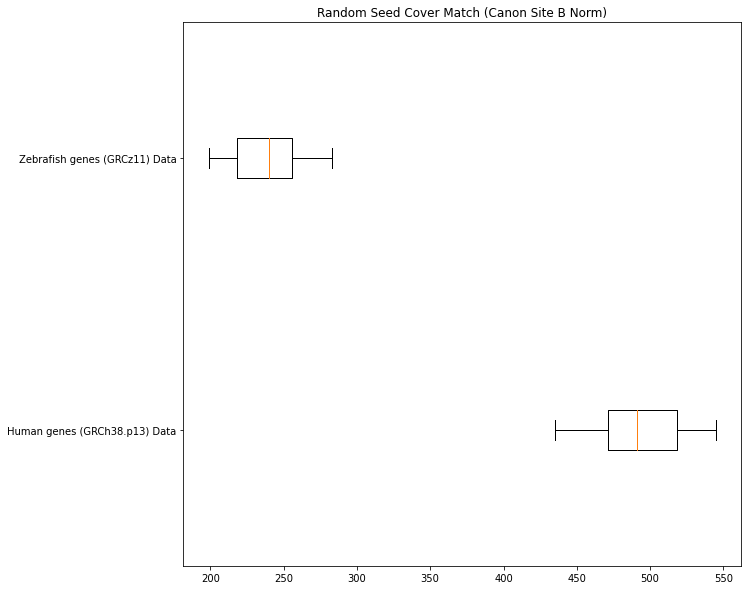

In [34]:
canon_site = 'B'
v_subset = 'Norm'
plot_match_seed_cover(canon_site, v_subset)